<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Data Augmentation

One of the most important steps when building a model for Computer Vision is data augmentation.
Using more training data can make the model generalize better, but it is very expensive to collect data.
Instead, augmenting the training data with minor alterations has been proven to work well.

In this notebook, we explore why the data augmentation works and how it affects the result of different image classification problems, *[MNIST](http://yann.lecun.com/exdb/mnist/)*, *Fridge Objects*<sup>*</sup>, and *[Planet](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data)*. We test some of basic transformations by using [fastai](https://docs.fast.ai/vision.transform.html) functions.

<sub>* To learn more about Fridge Objects dataset and performance, check out [training introduction notebook](01_training_introduction.ipynb)</sub>

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../")
import os
import random
from tempfile import TemporaryDirectory

import fastai
from fastai.vision import (
    # data modules
    untar_data, URLs,
    # model modules
    ClassificationInterpretation, cnn_learner, ImageList, imagenet_stats, models, to_np,
    # image transformation modules
    brightness, contrast, crop_pad, flip_lr, jitter,
    RandTransform, rotate, TfmAffine, TfmCrop, zoom,
)
from fastai.metrics import accuracy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch 

from utils_ic.constants import IMAGENET_IM_SIZE as IMAGE_SIZE
from utils_ic.datasets import unzip_url, Urls
from utils_ic.fastai_utils import TrainMetricsRecorder
from utils_ic.gpu_utils import which_processor
from utils_ic.plot_utils import plot_pr_roc_curves, ResultsWidget

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.48
Fast.ai (Torch) is using GPU: Tesla K80
Available / Total memory = 11430 / 11441 (MiB)


This shows your machine's GPUs (if has any) and which computing device fastai/torch is using. The output cells here show the run results on [Azure DSVM](https://azure.microsoft.com/en-us/services/virtual-machines/data-science-virtual-machines/) Standard NC6.

In [3]:
# Parameters
SEED          = 42  # Random seed
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet50
DATA_PATH     = 'data' # To cache the dataset for later use, set DATA_PATH

In [4]:
tmpdir = TemporaryDirectory()
if DATA_PATH is None:
    DATA_PATH = tmpdir.name
    
datasets = {}

## 1. Examples: Handwritten digit, fridge object, and satellite image

#### MNIST

In [5]:
# MNIST TINY
mnist_path = untar_data(
    URLs.MNIST_TINY,
    os.path.join(DATA_PATH, 'mnist.tgz'),
    DATA_PATH
)
mnist_path.ls()

/data/anaconda/envs/cvbp/lib/python3.6/site-packages/fastai/datasets.py:159: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


[PosixPath('data/mnist_tiny/models'),
 PosixPath('data/mnist_tiny/labels.csv'),
 PosixPath('data/mnist_tiny/test'),
 PosixPath('data/mnist_tiny/valid'),
 PosixPath('data/mnist_tiny/train')]

MNIST
Num train = 709, num valid = 699
Classes = ['3', '7']


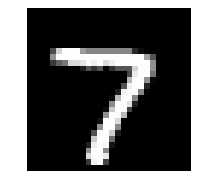

In [6]:
datasets['mnist'] = (
    ImageList.from_folder(mnist_path)
    .split_by_folder()
    .label_from_folder()
)

print("MNIST")
print(f"Num train = {len(datasets['mnist'].train)}, num valid = {len(datasets['mnist'].valid)}")
print(f"Classes = {datasets['mnist'].classes}")

datasets['mnist'].train.x[0].show()

#### Fridge Objects

*Fridge object* dataset consists of 134 images of can, carton, milk bottle and water bottle photos taken with different backgrounds.

In [7]:
fridge_path = unzip_url(Urls.fridge_objects_path, DATA_PATH, exist_ok=True)
fridge_path.ls()

[PosixPath('/data/home/jumin/git/cvbp/image_classification/notebooks/data/fridgeObjects/models'),
 PosixPath('/data/home/jumin/git/cvbp/image_classification/notebooks/data/fridgeObjects/water_bottle'),
 PosixPath('/data/home/jumin/git/cvbp/image_classification/notebooks/data/fridgeObjects/carton'),
 PosixPath('/data/home/jumin/git/cvbp/image_classification/notebooks/data/fridgeObjects/can'),
 PosixPath('/data/home/jumin/git/cvbp/image_classification/notebooks/data/fridgeObjects/milk_bottle')]

Fridge object
Num train = 67, num valid = 67
Classes = ['can', 'carton', 'milk_bottle', 'water_bottle']


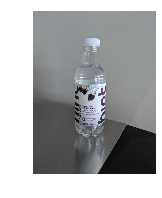

In [8]:
datasets['fridge'] = (
    ImageList.from_folder(fridge_path)
    .split_by_rand_pct(valid_pct=0.5, seed=SEED) 
    .label_from_folder()
)

print("Fridge object")
print(f"Num train = {len(datasets['fridge'].train)}, num valid = {len(datasets['fridge'].valid)}")
print(f"Classes = {datasets['fridge'].classes}")

datasets['fridge'].train.x[0].show()

#### Planet
The other dataset we want to visualize is Planet, the satellite images to track the human footprint in the Amazon rainforest.

In [9]:
# PLANET_TINY
planet_path = untar_data(
    URLs.PLANET_TINY,
    os.path.join(DATA_PATH, 'planet.tgz'),
    DATA_PATH
)
planet_path.ls()

/data/anaconda/envs/cvbp/lib/python3.6/site-packages/fastai/datasets.py:159: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


[PosixPath('data/planet_tiny/models'),
 PosixPath('data/planet_tiny/labels.csv'),
 PosixPath('data/planet_tiny/train')]

Planet
Num train = 100, num valid = 81
Classes = ['agriculture clear cultivation cultivation primary road water', 'agriculture clear cultivation habitation primary road', 'agriculture clear cultivation primary', 'agriculture clear cultivation primary road', 'agriculture clear habitation primary road', 'agriculture clear primary', 'agriculture clear primary road', 'agriculture clear primary road water', 'agriculture cultivation habitation haze primary road', 'agriculture cultivation habitation partly_cloudy primary road', 'agriculture cultivation partly_cloudy primary', 'agriculture cultivation partly_cloudy primary road water', 'agriculture habitation partly_cloudy primary road', 'agriculture partly_cloudy primary', 'agriculture partly_cloudy primary water', 'artisinal_mine clear primary road water', 'artisinal_mine clear primary water', 'artisinal_mine partly_cloudy primary water', 'bare_ground clear cultivation primary', 'blooming clear primary', 'clear cultivation primary water', 'c

/data/anaconda/envs/cvbp/lib/python3.6/site-packages/fastai/data_block.py:518: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
agriculture clear habitation primary road water, agriculture clear primary water, agriculture cultivation partly_cloudy primary road, agriculture bare_ground clear habitation primary road, agriculture blooming clear cultivation habitation primary...
  if getattr(ds, 'warn', False): warn(ds.warn)


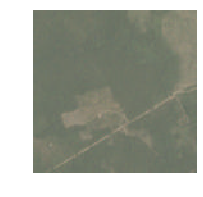

In [10]:
datasets['planet'] = (
    ImageList.from_csv(planet_path, 'labels.csv', folder='train', suffix='.jpg')
    .split_by_rand_pct(valid_pct=0.5, seed=SEED) 
    .label_from_df()
)

print("Planet")
print(f"Num train = {len(datasets['planet'].train)}, num valid = {len(datasets['planet'].valid)}")
print(f"Classes = {datasets['planet'].classes}")

datasets['planet'].train.x[2].show()

## 2. Image transformation

We test following transformations:
1. No transformation
1. Horizontal flip
1. Vertical flip
1. Rotations (up to 30-degree)
1. Zoom & crop
1. Brightness and contrast
1. Jitter

Note, each transform functions returns a tuple of two list of transforms: one for the training set and one for the validation set (the second list of transforms is limited to resizing the pictures). For the full list of transformation `fastai` supports, see [its API documents](https://docs.fast.ai/vision.transform.html).

In [11]:
def gen_tfms_options(p=0.5):
    """Genereate transformations w/ given probability.
    """
    valid_tfms = RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)
    return {
        'no_tfms': None,
        'flip_h': ([flip_lr(p=p)], [valid_tfms]),
        'flip_v': ([rotate(degrees=180, p=p), flip_lr(p=p)], [valid_tfms]),
        'rotation': ([rotate(degrees=(-30, 30), p=p)], [valid_tfms]),
        'zoom_crop': ([RandTransform(tfm=TfmAffine(zoom), kwargs={'scale': (0.75, 2)}, p=p, resolved={}, do_run=True, is_random=True)], [valid_tfms]),
        'bright_contrast': ([brightness(change=(0.1, 0.9), p=p), contrast(scale=(0.5, 2.0), p=p)], [valid_tfms]),
        'jitter': ([jitter(magnitude=(-0.05, 0.05), p=p)], [valid_tfms]),
    }

#### Examples of not-very-useful (or even bad) transformations vs. good transformations

Again, this will be pretty much dependent on the problem we would like to solve.


<img src="figs/augmentation_m_w.jpg" alt="m and w" width="200"/>

<center><i>You probablly do not want to vertical-flip letters</i></center>


In [12]:
def plot_ex(im, tfms_ops):
    _, axes = plt.subplots(1, len(tfms_ops), figsize=(3*len(tfms_ops), 3))
    for i, (name, tfms) in enumerate(tfms_ops.items()):
        if tfms is None:
            im.show(ax=axes[i], title=name)
        else:
            random_seed(SEED)
            im.apply_tfms(tfms[0]).show(ax=axes[i], title=name)  # tfms[0]: tfms for the training set

def random_seed(s):
    np.random.seed(s)
    torch.manual_seed(s)
    random.seed(s)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(s)
        torch.cuda.manual_seed_all(s)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

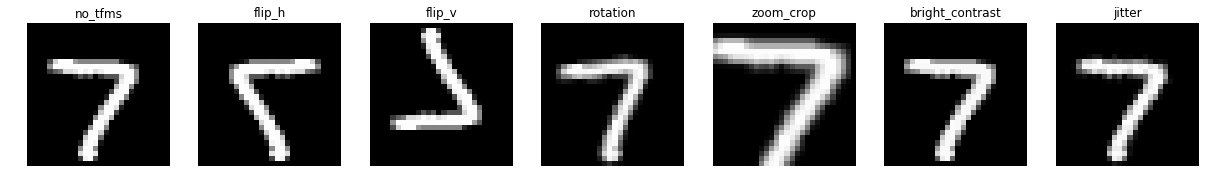

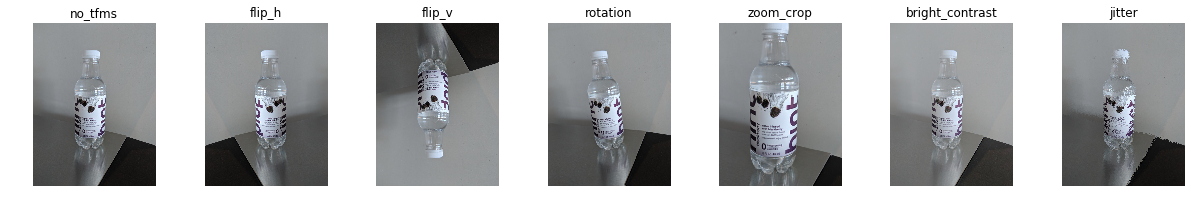

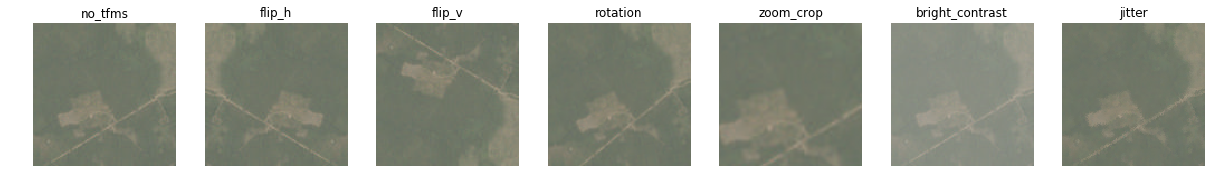

In [13]:
# TODO use own photos

tfms_options = gen_tfms_options(1)
plot_ex(datasets['mnist'].train.x[0], tfms_options)
plot_ex(datasets['fridge'].train.x[0], tfms_options)
plot_ex(datasets['planet'].train.x[2], tfms_options)

## 3. Training and evaluation 

In [14]:
df_results = pd.DataFrame(columns=['data', 'transform', 'train_acc', 'valid_acc'])
tfms_options = gen_tfms_options(0.5)
interps = {}  # Cache ClassificationInterpretation objects

for dn, d in datasets.items():
    itp = {}
    for tn, tfms in tfms_options.items():
        print(f"{dn} {tn}")
        # Use 1 workder for the databunch for reproducibility
        data = d.transform(tfms, size=IMAGE_SIZE).databunch(bs=BATCH_SIZE, num_workers=1).normalize(imagenet_stats)
        
        # Set seed to reproduce the results, 
        random_seed(SEED)  
        learn = cnn_learner(
            data,
            ARCHITECTURE,
            metrics=[accuracy],
            callback_fns=[TrainMetricsRecorder]
        )
        learn.fit_one_cycle(5)

        train_metrics = learn.train_metrics_recorder.last_train_metrics()
        valid_metrics = learn.train_metrics_recorder.last_valid_metrics()
        row = [dn, tn, f"{100*float(train_metrics[0]):3.2f}", f"{100*float(valid_metrics[0]):3.2f}"]

        df_results.loc[df_results.shape[0] + 1] = row
        itp[tn] = ClassificationInterpretation.from_learner(learn)
    
    interps[dn] = itp


In [15]:
df_results

,data,transform,train_acc,valid_acc
1,mnist,no_tfms,99.01,100.00
2,mnist,flip_h,98.72,99.71
3,mnist,flip_v,97.59,99.57
4,mnist,rotation,97.02,99.71
5,mnist,zoom_crop,96.31,99.71
6,mnist,bright_contrast,97.02,99.86
7,mnist,jitter,98.15,99.14
8,fridge,no_tfms,98.44,92.54
9,fridge,flip_h,96.88,94.03
10,fridge,flip_v,96.88,91.04


TODO results analysis

- Show examples of top loss and describe why a specific transforms did not work


In [16]:
dn = 'mnist'
tn = 'zoom_crop'

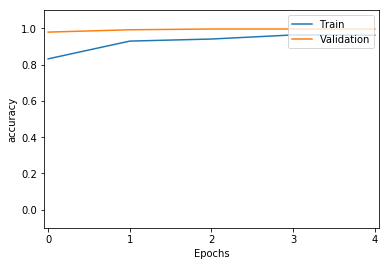

mnist data with zoom_crop transforms


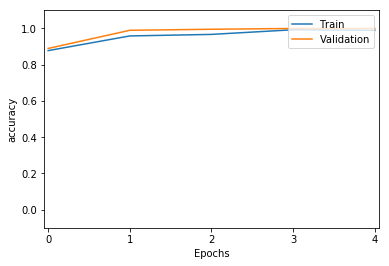

mnist without transformation


In [22]:
interps[dn][tn].learn.train_metrics_recorder.plot()
print(f"{dn} data with {tn} transforms")
interps[dn]['no_tfms'].learn.train_metrics_recorder.plot()
print(f"{dn} without transformation")

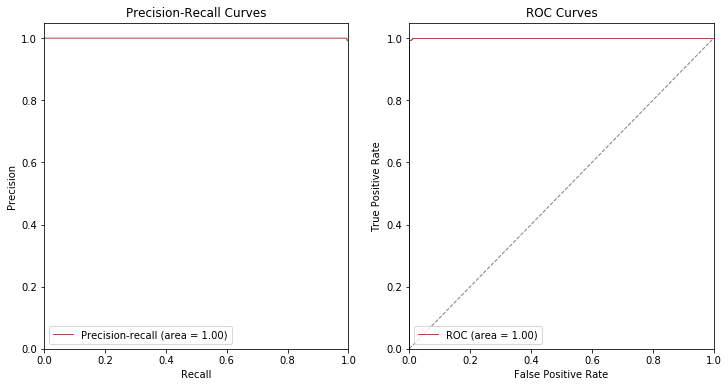

In [23]:
plot_pr_roc_curves(to_np(interps[dn][tn].y_true), to_np(interps[dn][tn].probs), datasets[dn].classes)

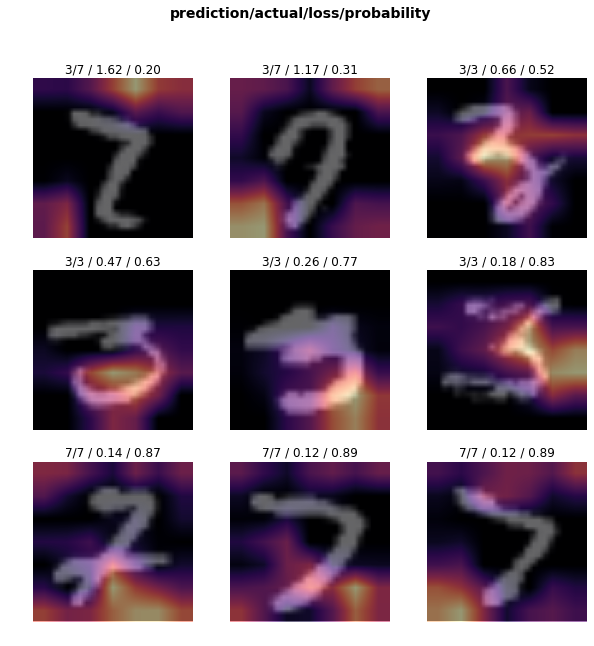

In [24]:
interps[dn][tn].plot_top_losses(9, figsize=(10,10))

In [ ]:
# Cleanup
tmpdir.cleanup()